## Loss sensitivity analysis

Even though are many similarity metrics in the audio domain, it is still not a trival task to find a measure correlated with the actual similarity perceived by humans. 
Simple distance metrics fail to replicate the sensitivity and robustness of the auditory system. As a response to that limitation, various more or less auditory-inspired
loss functions (mel-spectrogram, multi-resolution stft loss, etc.) and objective metrics (pesq, stoi) have been developed but it is not clear what are the exact limitations 
of these methods in assessing the similarity between the signals. 

We developed a DNN-based system whose goal is to change the reverberation of an input sound. To evaluate this system, we need a measure which would be able to "see" the
difference between two audios with different reverberations. It is not clear whether existing loss functions are sensitive to that aspect of the sound. 
The goal of this notebook is to reveal which of the commonly used audio losses is sensitive to a change in acoustic environment. 

Ideally, the signals coming from different acoustic environments should result in a high loss value (low similarity) and signals from the same acoustic environment should result in a low loss value (high similarity). We create the corresponding two categories of signal pairs:

- s1r1 and s1r2 (same speech sample convolved with two different simulated RIRs from different rooms)
- s1r1a and s1r1h (same speech sample convolved with two different simulated RIRs from the same room, but at different positions)

we generate 1000 signal pairs in each category, using synthetic impulse responses from randomly generated shoebox rooms (generated with masp).

In [2]:
################## IMPORT LIBRARIES ##################
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
import seaborn as sns

In [99]:
################## DEFINE FUNCTIONS ##################

def compute_and_plot_rocs(losstype, df_losses, x_range=None, flipsign=False):
    # full reverb signal:
    data_diff_rooms=df_losses[df_losses["compared"]=="room1:room2"][losstype].tolist()
    data_same_rooms=df_losses[df_losses["compared"]=="room1a:room1b"][losstype].tolist()
    # early reflections
    data_diff_rooms_e=df_losses[df_losses["compared"]=="room1:room2 (early)"][losstype].tolist()
    data_same_rooms_e=df_losses[df_losses["compared"]=="room1a:room1b (early)"][losstype].tolist()
    # late reverb
    data_diff_rooms_l=df_losses[df_losses["compared"]=="room1:room2 (late)"][losstype].tolist()
    data_same_rooms_l=df_losses[df_losses["compared"]=="room1a:room1b (late)"][losstype].tolist()

    # Plot distribu
    plt.rcParams.update({'font.size': 8}) 
    plt.figure(figsize=(12,3))
    plt.subplot(1,4,3)
    plt.hist(data_diff_rooms, alpha=0.5,bins=50,label="room1:room2",density=True) 
    plt.hist(data_same_rooms, alpha=0.5,bins=50,label="room1a:room1b",density=True)
    if x_range!=None:
        plt.xlim(x_range)
    plt.title("Full signal")
    plt.subplot(1,4,1)
    plt.hist(data_diff_rooms_e, alpha=0.5,bins=50,label="room1:room2",density=True)
    plt.hist(data_same_rooms_e, alpha=0.5,bins=50,label="room1a:room1b",density=True)
    if x_range!=None:
        plt.xlim(x_range)
    plt.title("Early reflections")
    plt.subplot(1,4,2)
    plt.hist(data_diff_rooms_l, alpha=0.5,bins=50,label="room1:room2",density=True)
    plt.hist(data_same_rooms_l, alpha=0.5,bins=50,label="room1a:room1b",density=True)
    if x_range!=None:
        plt.xlim(x_range)
    plt.title("Late reverb")
    plt.legend()


    # Compute ROC to see if the network is able to distinguish between two enviromnents
    import sklearn.metrics as metrics
    binary_labels=[0 for i in range(len(data_same_rooms))] + [1 for i in range(len(data_diff_rooms))]
    vals=data_same_rooms+data_diff_rooms
    vals_e=data_same_rooms_e+data_diff_rooms_e
    vals_l=data_same_rooms_l+data_diff_rooms_l

    fpr, tpr, thresholds = metrics.roc_curve(binary_labels,vals)
    fpr_e, tpr_e, thresholds_e = metrics.roc_curve(binary_labels,vals_e)
    fpr_l, tpr_l, thresholds_l = metrics.roc_curve(binary_labels,vals_l)

    if flipsign==True:
        fpr=1-fpr; tpr=1-tpr
        fpr_e=1-fpr_e; tpr_e=1-tpr_e
        fpr_l=1-fpr_l; tpr_l=1-tpr_l

    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_e = metrics.auc(fpr_e, tpr_e)
    roc_auc_l = metrics.auc(fpr_l, tpr_l)
    plt.subplot(1,4,4)
    plt.plot(fpr,tpr,label=f"reverberant signal, AUC={roc_auc:.2f}")
    plt.plot(fpr_e,tpr_e,label=f"early reflections, AUC={roc_auc_e:.2f}")
    plt.plot(fpr_l,tpr_l,label=f"late reverb, AUC={roc_auc_l:.2f}")
    plt.title(f'ROC curve')
    plt.legend()
    plt.suptitle("Loss: " +losstype)
    plt.tight_layout()
    plt.show()

    # plt.show()
    # plt.figure()
    # plt.plot(thresholds,label=f"reverberant signal, AUC={roc_auc:.2f}")
    # plt.plot(thresholds_e,label=f"early reflections, AUC={roc_auc_e:.2f}")
    # plt.plot(thresholds_l,label=f"late reverb, AUC={roc_auc_l:.2f}")
    # plt.title(f'Thresholds\n Based on loss={losstype}')
    # plt.legend()
    # plt.show()



def compare_losses_AUC(df_losses):
    all_losses = [key for key in df_losses.keys() if key.startswith('L')]
    flip_losses =["L_sisdr", "L_pesq", "L_stoi"]

    roc_auc=[]
    roc_auc_e=[]
    roc_auc_l=[]
    for loss in all_losses:

        if loss in flip_losses:
            flipsign=True
        else:
            flipsign=False

        # full reverb signal:
        data_diff_rooms=df_losses[df_losses["compared"]=="room1:room2"][loss].tolist()
        data_same_rooms=df_losses[df_losses["compared"]=="room1a:room1b"][loss].tolist()
        # early reflections
        data_diff_rooms_e=df_losses[df_losses["compared"]=="room1:room2 (early)"][loss].tolist()
        data_same_rooms_e=df_losses[df_losses["compared"]=="room1a:room1b (early)"][loss].tolist()
        # late reverb
        data_diff_rooms_l=df_losses[df_losses["compared"]=="room1:room2 (late)"][loss].tolist()
        data_same_rooms_l=df_losses[df_losses["compared"]=="room1a:room1b (late)"][loss].tolist()

        # Compute ROC to see if the network is able to distinguish between two enviromnents
        import sklearn.metrics as metrics
        binary_labels=[0 for i in range(len(data_same_rooms))] + [1 for i in range(len(data_diff_rooms))]
        vals=data_same_rooms+data_diff_rooms
        vals_e=data_same_rooms_e+data_diff_rooms_e
        vals_l=data_same_rooms_l+data_diff_rooms_l

        fpr, tpr, thresholds = metrics.roc_curve(binary_labels,vals)
        fpr_e, tpr_e, thresholds_e = metrics.roc_curve(binary_labels,vals_e)
        fpr_l, tpr_l, thresholds_l = metrics.roc_curve(binary_labels,vals_l)

        if flipsign==True:
            fpr=1-fpr; tpr=1-tpr
            fpr_e=1-fpr_e; tpr_e=1-tpr_e
            fpr_l=1-fpr_l; tpr_l=1-tpr_l
        roc_auc.append(metrics.auc(fpr, tpr))
        roc_auc_e.append(metrics.auc(fpr_e, tpr_e))
        roc_auc_l.append(metrics.auc(fpr_l, tpr_l))

    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plt.bar(all_losses,roc_auc_e)
    plt.axhline(y=0.8, color='r', linestyle='--', linewidth=1) 
    plt.xticks(rotation=45,ha='right')
    plt.ylim((0.5,1))
    plt.title("discrimination quality for early reflections")
    plt.subplot(1,3,2)
    plt.bar(all_losses,roc_auc_l)
    plt.axhline(y=0.8, color='r', linestyle='--', linewidth=1) 
    plt.xticks(rotation=45,ha='right')
    plt.ylim((0.5,1))
    plt.title("discrimination quality for late reverb")
    plt.subplot(1,3,3)
    plt.bar(all_losses,roc_auc)
    plt.axhline(y=0.8, color='r', linestyle='--', linewidth=1) 
    plt.xticks(rotation=45,ha='right')
    plt.ylim((0.5,1))
    plt.title("discrimination quality for full signal")
    plt.tight_layout()
    plt.show()

In [100]:
################## LOAD DATA FRAME WITH LOSS VALUES ##################
df_losses_randmic=pd.read_csv("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-09-05-2024/eval_detection_randmicpos.csv")
df_losses_fixedmic=pd.read_csv("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-09-05-2024/eval_detection_fixedmicpos.csv")

# Compute multi-resolution stft loss = magnitude loss + spectral convergence loss
df_losses_randmic["L_multi-stft"]=df_losses_randmic["L_multi-stft-sc"]+df_losses_randmic["L_multi-stft-mag"]
df_losses_fixedmic["L_multi-stft"]=df_losses_fixedmic["L_multi-stft-sc"]+df_losses_fixedmic["L_multi-stft-mag"]
df_losses_randmic["L_stft"]=df_losses_fixedmic["L_stft-sc"]+df_losses_fixedmic["L_stft-mag"]
df_losses_fixedmic["L_stft"]=df_losses_fixedmic["L_stft-sc"]+df_losses_fixedmic["L_stft-mag"]

# Display first 10 rows of a dataframe with losses
df_losses_randmic.head(10)

,label,idx,compared,L_multi-stft-sc,L_multi-stft-mag,L_multi-mel,L_multi-wave,L_stft-sc,L_stft-mag,L_logmel,L_wave,L_sisdr,L_srmr_1,L_srmr_2,L_pesq,L_stoi,L_emb_cos,L_emb_euc,L_multi-stft,L_stft
0,14-05-2024--23-12_c_wunet_stft_1,0,room1:room2,0.316086,0.627107,0.140706,0.044319,0.315618,0.671752,0.876051,0.055278,6.976589,3.788909,4.239367,2.276715,0.956383,0.012333,0.431371,0.943193,1.261339
1,14-05-2024--23-12_c_wunet_stft_1,0,room1:room2 (early),0.289447,0.454553,0.081778,0.040698,0.287217,0.464420,0.362157,0.050735,7.684930,4.341398,4.291925,3.238695,0.969325,0.005135,0.279744,0.744000,0.999413
2,14-05-2024--23-12_c_wunet_stft_1,0,room1:room2 (late),1.598770,1.493793,0.581614,0.028735,1.598706,1.557751,8.740893,0.036119,-25.510632,2.489781,6.006398,1.256881,0.647427,0.011584,0.436763,3.092563,3.301848
3,14-05-2024--23-12_c_wunet_stft_1,0,room1a:room1b,0.308683,0.585641,0.126126,0.046415,0.305499,0.599340,0.617432,0.067269,5.165019,3.788909,5.272465,2.553021,0.926049,0.004800,0.266997,0.894324,0.896092
4,14-05-2024--23-12_c_wunet_stft_1,0,room1a:room1b (early),0.269165,0.526239,0.133271,0.043657,0.265063,0.534315,0.652828,0.064534,6.935427,4.341398,6.504234,2.957182,0.954467,0.007960,0.344468,0.795404,0.745102
5,14-05-2024--23-12_c_wunet_stft_1,0,room1a:room1b (late),0.603130,0.724008,0.170500,0.013243,0.608448,0.714477,1.177785,0.012036,-18.444334,2.489781,2.558872,1.405165,0.630859,0.004680,0.290091,1.327139,1.308555
6,14-05-2024--23-12_c_wunet_stft_1,0,prediction:target,0.340331,0.582985,0.128578,0.052374,0.337238,0.609031,0.725954,0.065022,7.567456,4.511315,4.239367,2.554473,0.952931,0.006719,0.319842,0.923316,1.138832
7,14-05-2024--23-12_c_wunet_stft_1,0,prediction:content,0.231918,0.312648,0.101558,0.033419,0.236300,0.341524,0.419606,0.037571,9.793440,4.511315,3.788909,3.488325,0.971341,0.007565,0.337637,0.544565,0.607446
8,14-05-2024--23-12_c_wunet_stft_1,1,room1:room2,0.451015,0.648333,0.182776,0.049133,0.447022,0.658699,1.711516,0.058810,2.490037,4.201978,5.761597,1.879950,0.849194,0.011672,0.411334,1.099348,1.219557
9,14-05-2024--23-12_c_wunet_stft_1,1,room1:room2 (early),0.422024,0.529934,0.126014,0.049144,0.420791,0.534387,0.812912,0.062143,3.471748,4.422055,7.172596,2.112414,0.885052,0.007249,0.325565,0.951958,0.995353


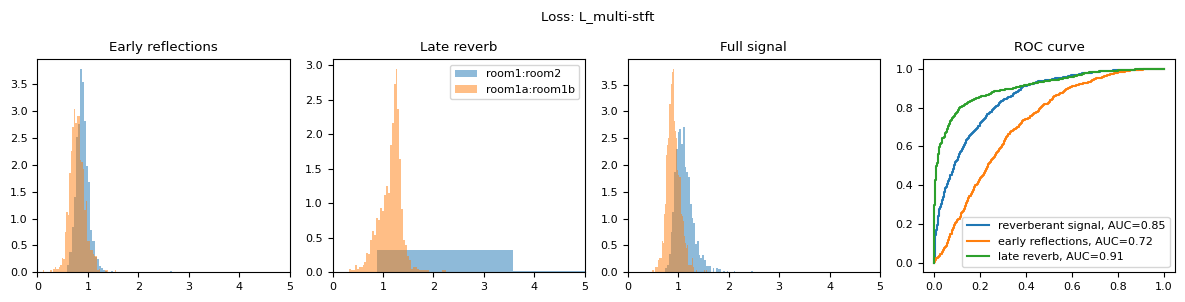

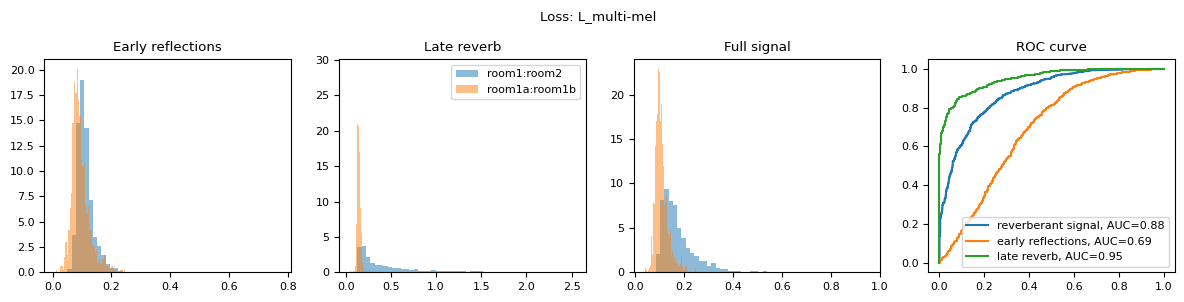

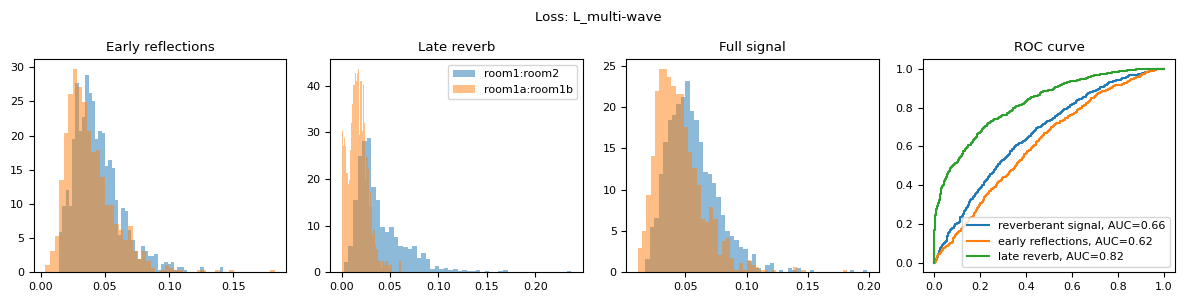

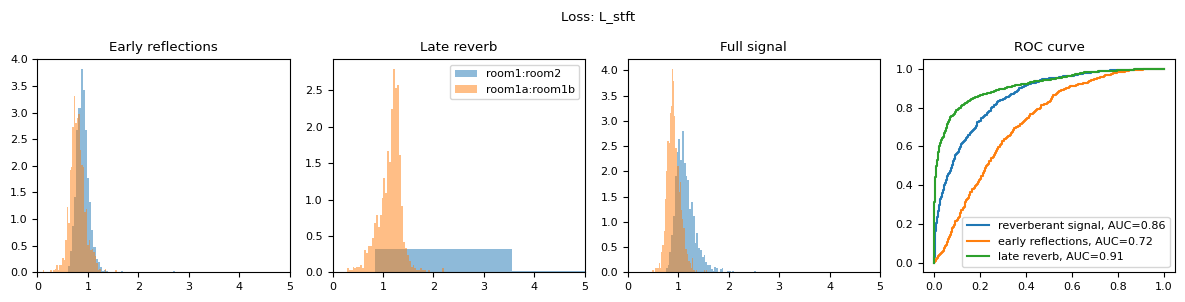

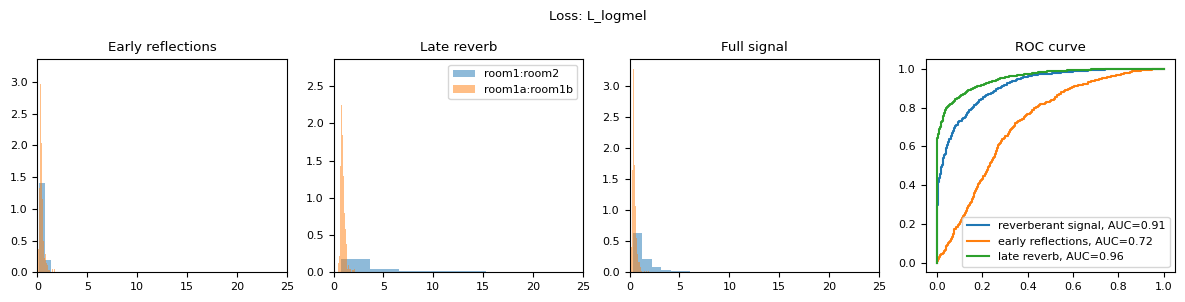

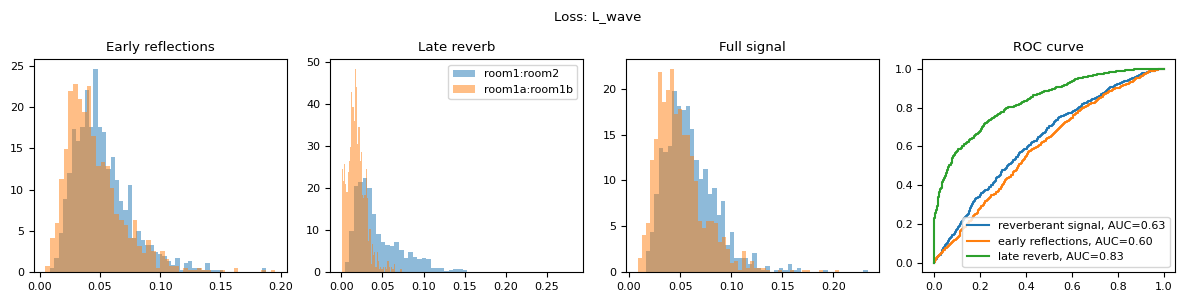

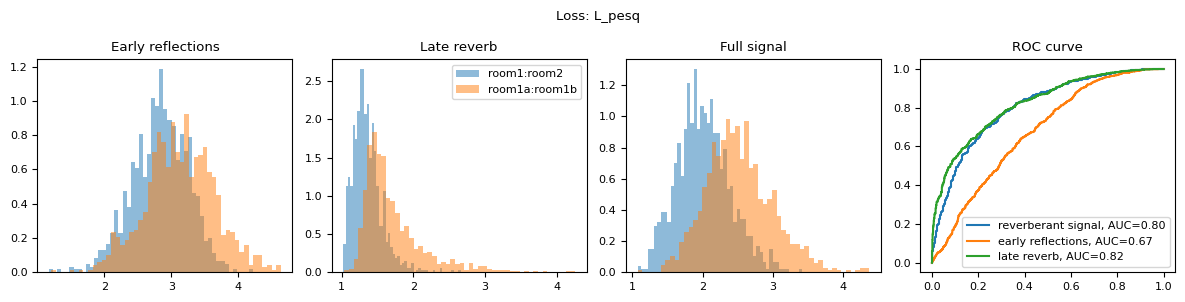

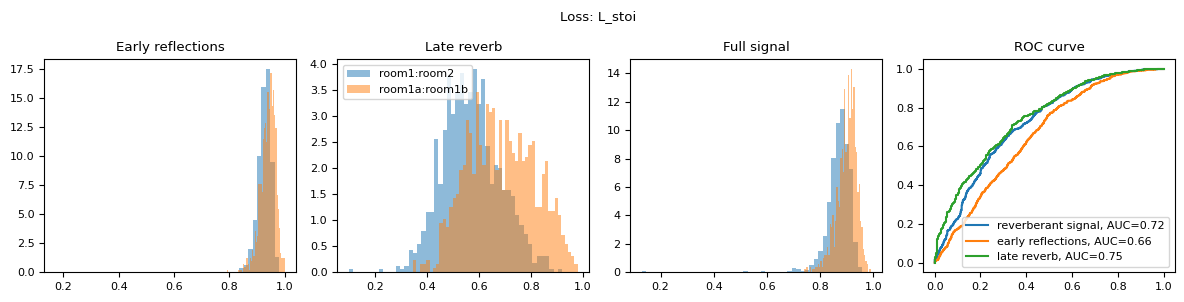

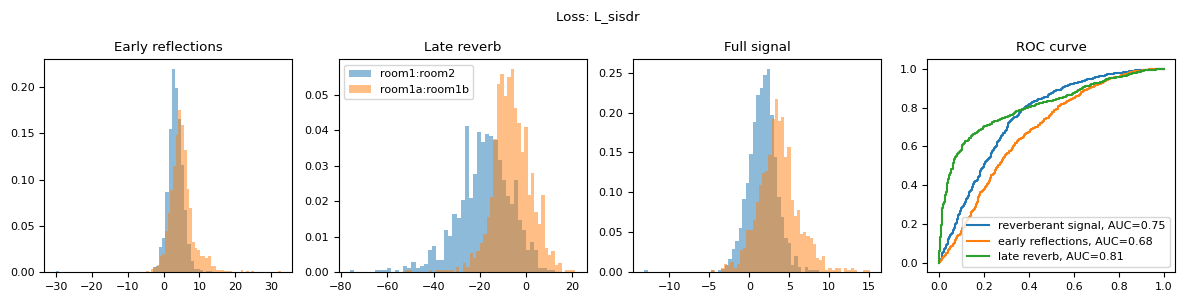

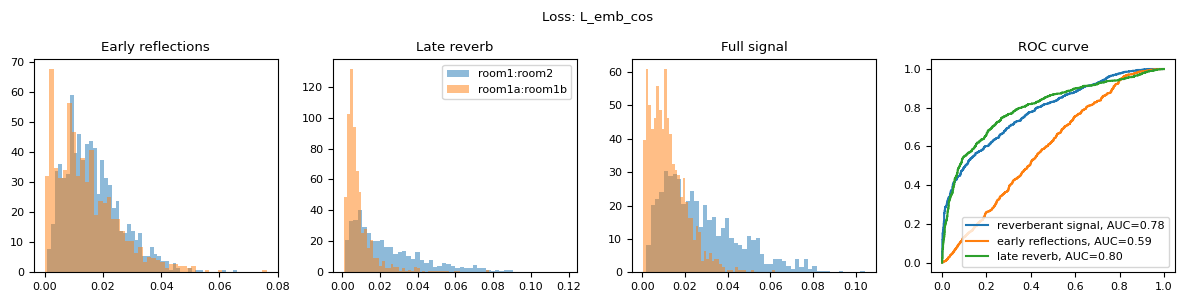

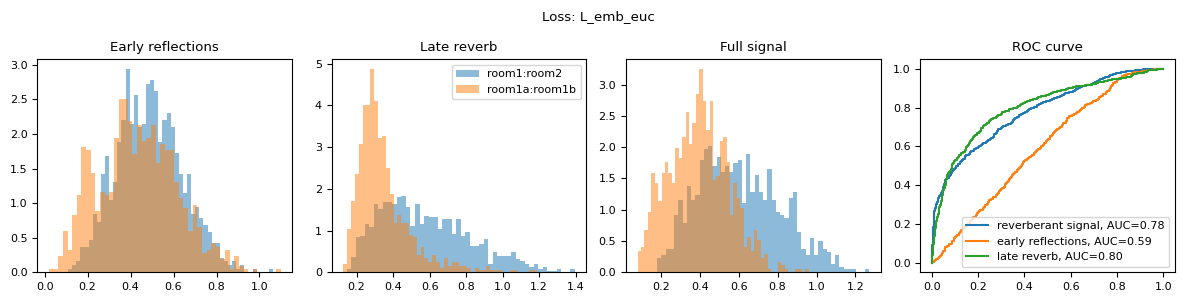

In [101]:
################## PLOT DISTRIBUTION OF VALUES &  ROC CURVES ##################
################# PAIRS WITH FIXED SRC_REC DISTANCE DISTANCE ##################
compute_and_plot_rocs("L_multi-stft", df_losses_fixedmic,x_range=(0,5))
compute_and_plot_rocs("L_multi-mel", df_losses_fixedmic)
compute_and_plot_rocs("L_multi-wave", df_losses_fixedmic)

compute_and_plot_rocs("L_stft", df_losses_fixedmic,x_range=(0,5))
compute_and_plot_rocs("L_logmel", df_losses_fixedmic,x_range=(0,25))
compute_and_plot_rocs("L_wave", df_losses_fixedmic)


compute_and_plot_rocs("L_pesq", df_losses_fixedmic,flipsign=True)
compute_and_plot_rocs("L_stoi", df_losses_fixedmic,flipsign=True)


compute_and_plot_rocs("L_sisdr", df_losses_fixedmic,flipsign=True)
compute_and_plot_rocs("L_emb_cos", df_losses_fixedmic)
compute_and_plot_rocs("L_emb_euc", df_losses_fixedmic)



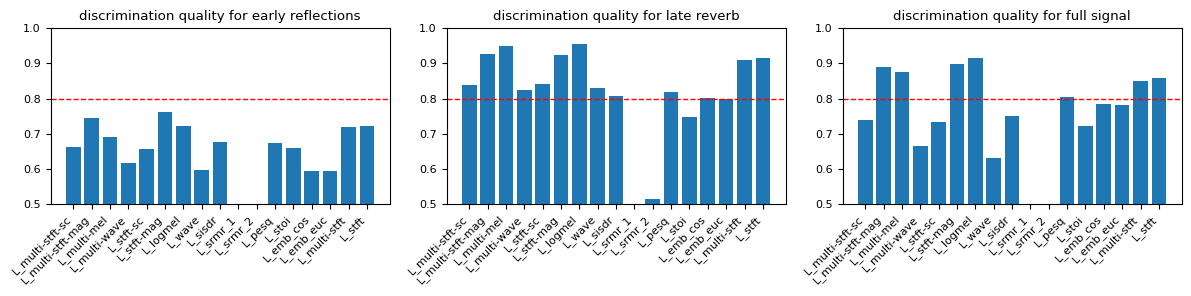

In [102]:
compare_losses_AUC(df_losses_fixedmic)

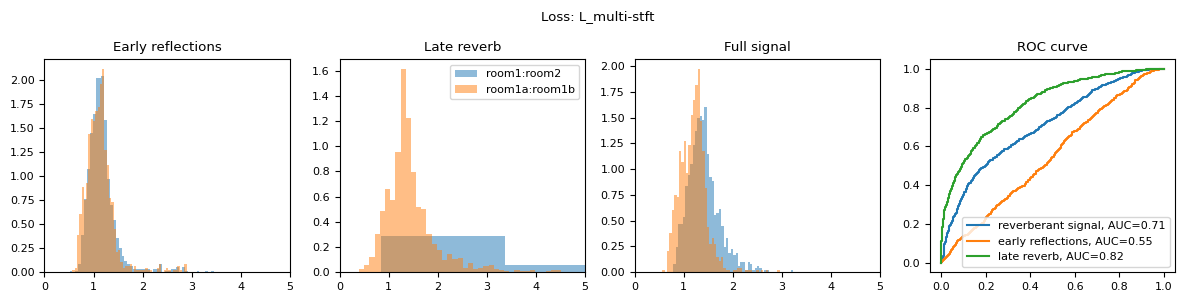

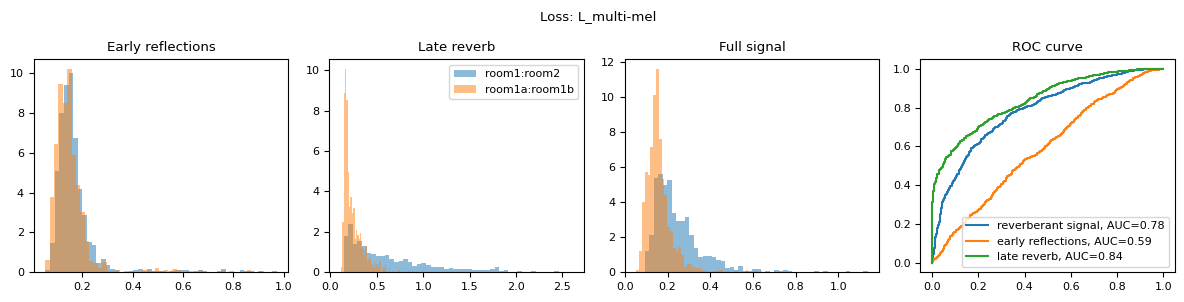

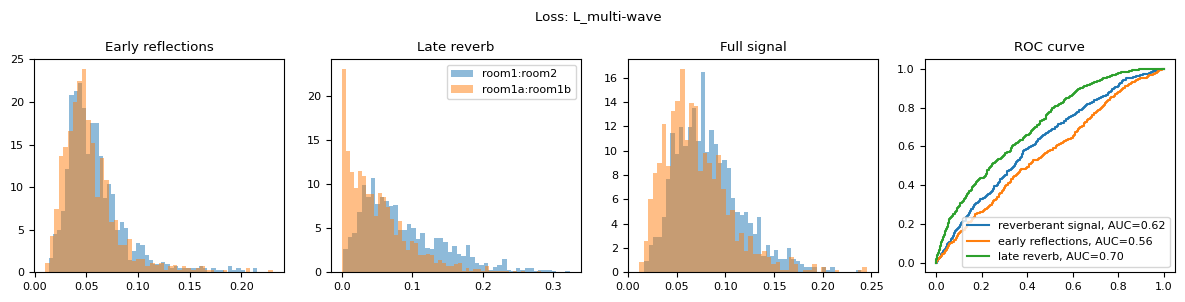

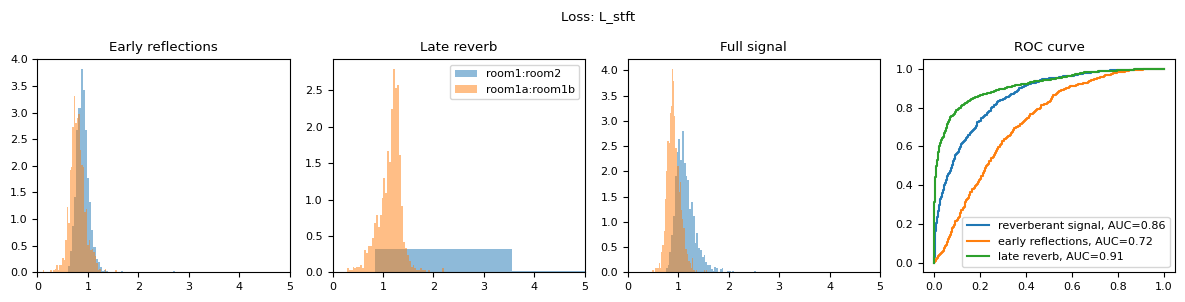

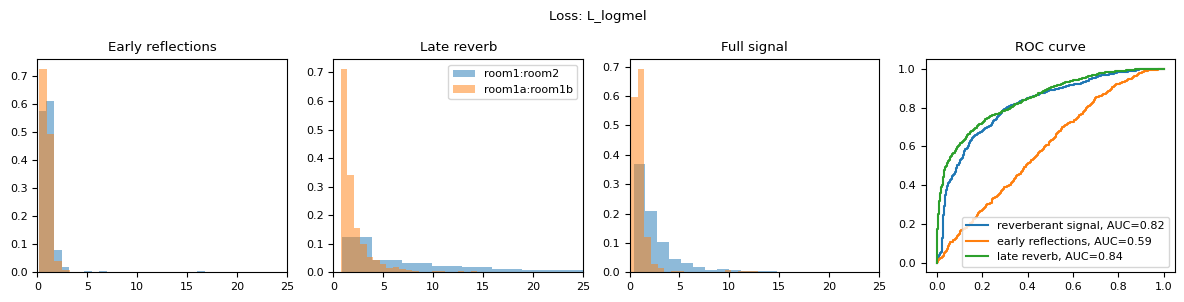

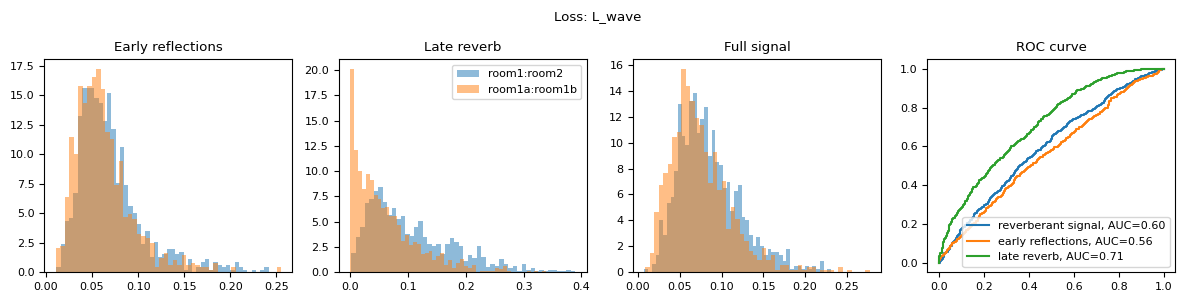

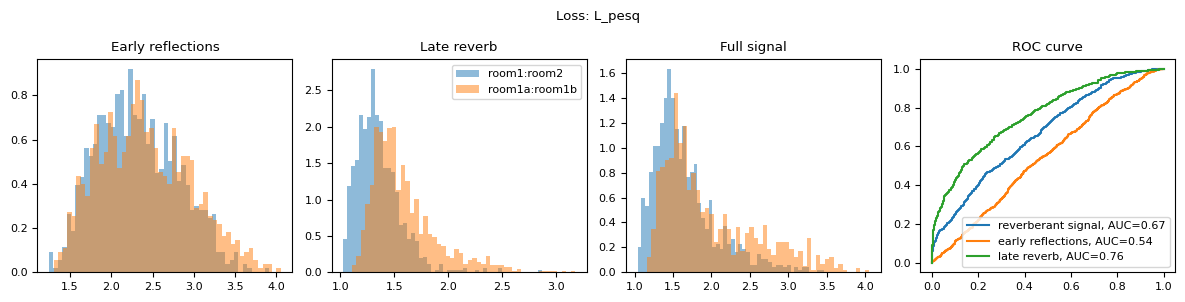

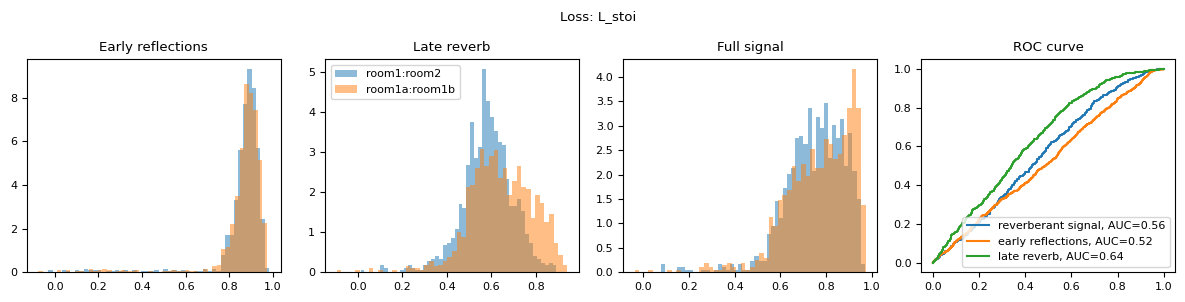

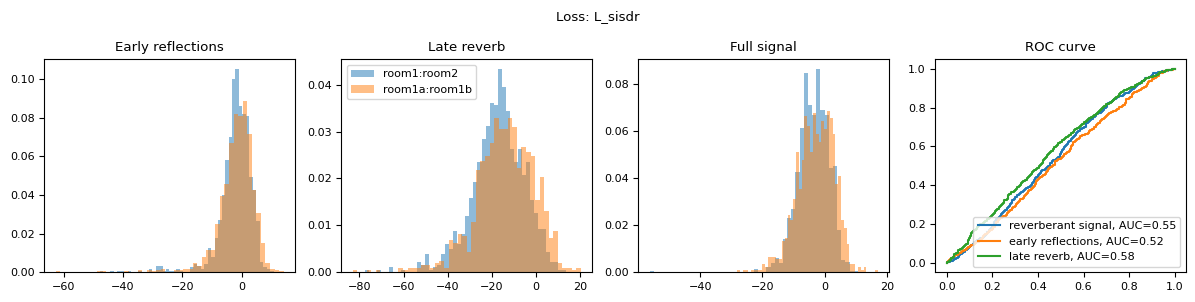

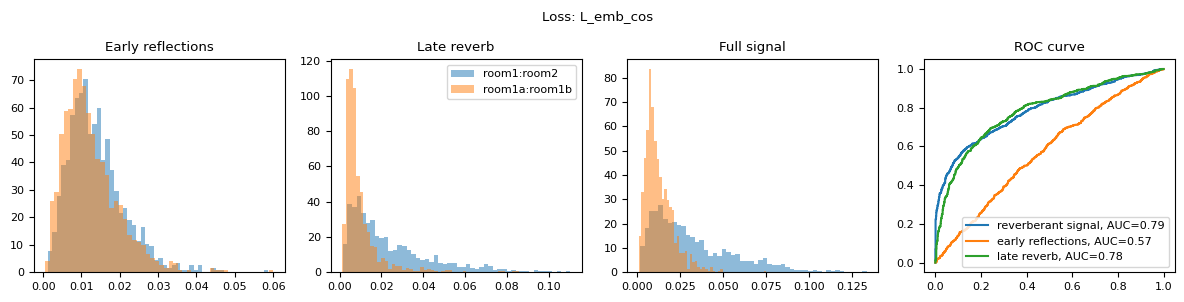

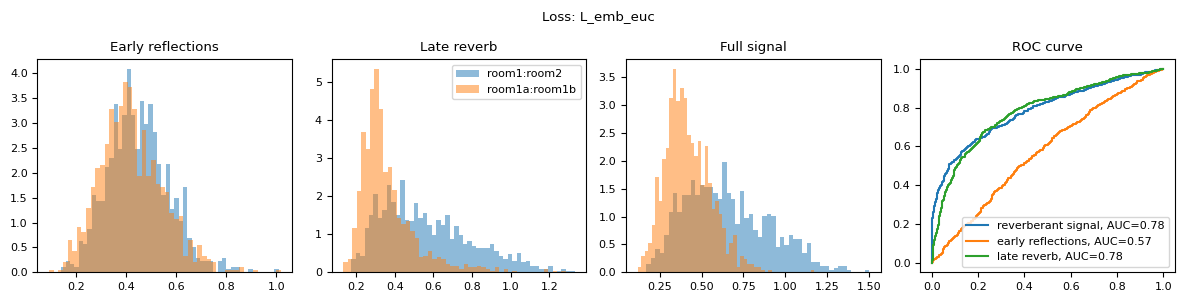

In [79]:
################## PLOT DISTRIBUTION OF VALUES &  ROC CURVES ##################
################# PAIRS WITH FIXED SRC_REC DISTANCE DISTANCE ##################

compute_and_plot_rocs("L_multi-stft", df_losses_randmic,x_range=(0,5))
compute_and_plot_rocs("L_multi-mel", df_losses_randmic)
compute_and_plot_rocs("L_multi-wave", df_losses_randmic)

compute_and_plot_rocs("L_stft", df_losses_randmic,x_range=(0,5))
compute_and_plot_rocs("L_logmel", df_losses_randmic,x_range=(0,25))
compute_and_plot_rocs("L_wave", df_losses_randmic)

compute_and_plot_rocs("L_pesq", df_losses_randmic,flipsign=True)
compute_and_plot_rocs("L_stoi", df_losses_randmic,flipsign=True)


compute_and_plot_rocs("L_sisdr", df_losses_randmic,flipsign=True)
compute_and_plot_rocs("L_emb_cos", df_losses_randmic)
compute_and_plot_rocs("L_emb_euc", df_losses_randmic)


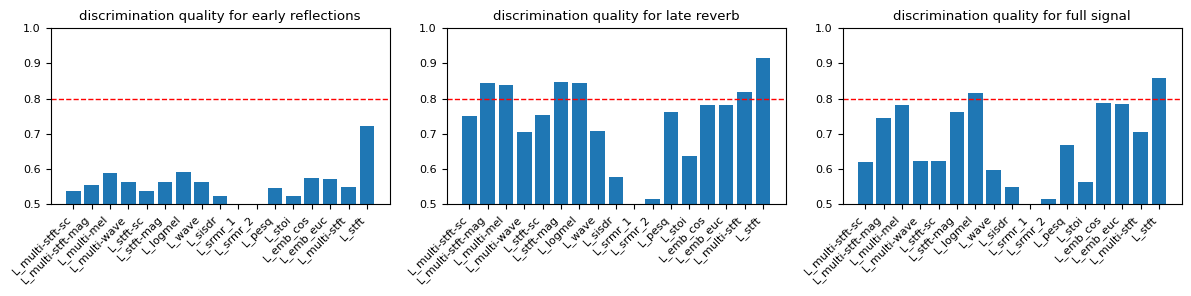

In [104]:
compare_losses_AUC(df_losses_randmic)